<a href="https://colab.research.google.com/github/jh2277/My_face/blob/main/U_gat_it_(AnimeCharacter)model%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-GAT-IT 모델을 이용해 사진을 캐릭터로 바꿔보자!         

In [ ]:
!git clone https://github.com/kairess/UGATIT

In [ ]:
!pip install tensorflow==1.13.1

In [ ]:
%cd UGATIT

In [ ]:
import tensorflow as tf # tensorflow 1.13.1+
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

from UGATIT_noargs import UGATIT

tf.logging.set_verbosity(tf.logging.ERROR)

## Pretraind model을 불러옵시다.
https://drive.google.com/file/d/19xQK2onIy-3S5W5K-XIh85pAg_RNvBVf/view?usp=sharing  
1. 위 링크에서 파일을 내 PC에 다운받아주세요.
2. 내 드라이브에 저장해주세요.
3. 구글마운트를 한 후, 드라이브 경로를 checkpoint변수에 저장해주세요.  
파일 용량이 커서, wget이나, gdown으로 받은 후, unzip하면 파일이 깨지니 안전하게 내 구글드라이브에 올려서 사용해주세요~

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 여기 경로를 여러분들 환경에 맞게 변경해주세요.
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/dataset/UGATIT.model-1000000'


sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

gan = UGATIT()
gan.build_model()

saver = tf.train.Saver()
saver.restore(sess, checkpoint_path)

print('Model loaded!')

그림이 잘 나오는지 확인해볼까요?

In [ ]:
img_path = 'imgs/bp_lisa.jpg'

img = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

brightness = 0
contrast = 30
img = np.int16(img)
img = img * (contrast / 127 + 1) - contrast + brightness
img = np.clip(img, 0, 255)
img = np.uint8(img)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.imshow(img)

미리 사전에 훈련된 face landmark를 통해서 얼굴의 위치를 찾고 얼굴만 출력해보겠습니다.

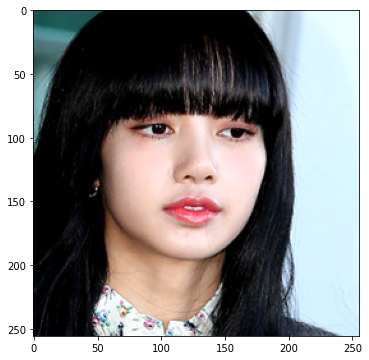

In [ ]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('checkpoint/shape_predictor_5_face_landmarks.dat')

dets = detector(img)
s = sp(img, dets[0])
img = dlib.get_face_chip(img, s, size=256, padding=0.65)

plt.figure(figsize=(6, 6))
plt.imshow(img)

 이제는 전처리 작업을 한 뒤, 모델을 통해 이미지를 캐릭터로 바꿔보겠습니다.

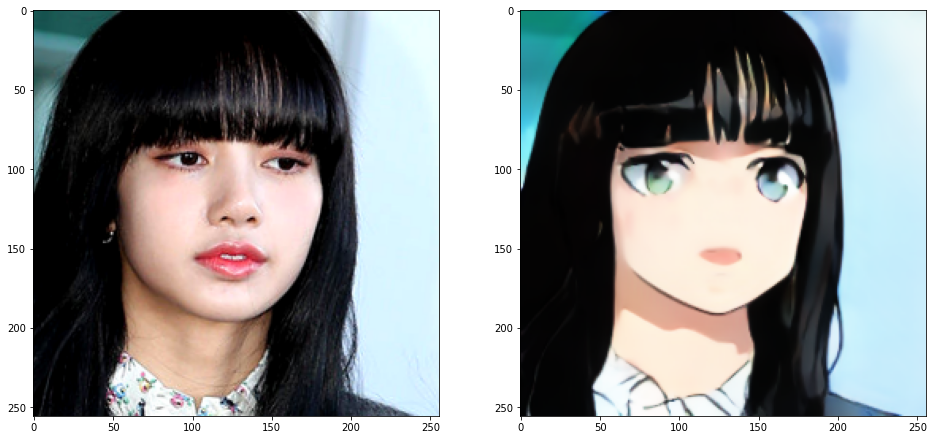

In [ ]:
# preprocessing
img_input = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
img_input = np.expand_dims(img_input, axis=0)
img_input = img_input / 127.5 - 1

# inference
img_output = sess.run(gan.test_fake_B, feed_dict={gan.test_domain_A: img_input})

# postprocessing
img_output = (img_output + 1) * 127.5
img_output = img_output.astype(np.uint8).squeeze()

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(img)
ax[1].imshow(img_output)

## Test
위에서 실행한 코드를 함수로 만들어서 간편하게 테스트할수 있도록 만들어보겠습니다.

In [ ]:
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('checkpoint/shape_predictor_5_face_landmarks.dat')

def selfie2anime(img_path):
    img = cv2.imread(img_path, flags=cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    brightness = 0
    contrast = 30
    img = np.int16(img)
    img = img * (contrast / 127 + 1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)

    dets = detector(img)
    
    if len(dets) == 0:
        print('No faces!')
        result = None
    else:
        # don't crop if face is too big
        if dets[0].width() < img.shape[1] * 0.55:
            s = sp(img, dets[0])
            img = dlib.get_face_chip(img, s, size=256, padding=0.65)

        # preprocessing
        img_input = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
        img_input = np.expand_dims(img_input, axis=0)
        img_input = img_input / 127.5 - 1

        # inference
        img_output = sess.run(gan.test_fake_B, feed_dict={gan.test_domain_A: img_input})

        # postprocessing
        img_output = (img_output + 1) * 127.5
        img_output = img_output.astype(np.uint8).squeeze()
        
        result = np.hstack([cv2.resize(img, (256, 256)), img_output])
        
        plt.figure(figsize=(16, 8))
        plt.axis('off')
        plt.imshow(result)

        cv2.imwrite('result/%s' % os.path.basename(img_path), result[:, :, ::-1])

    return result

## UpLoad

In [ ]:
from google.colab import files
file_uploaded = files.upload()

In [ ]:
img = list(file_uploaded.keys())[0]

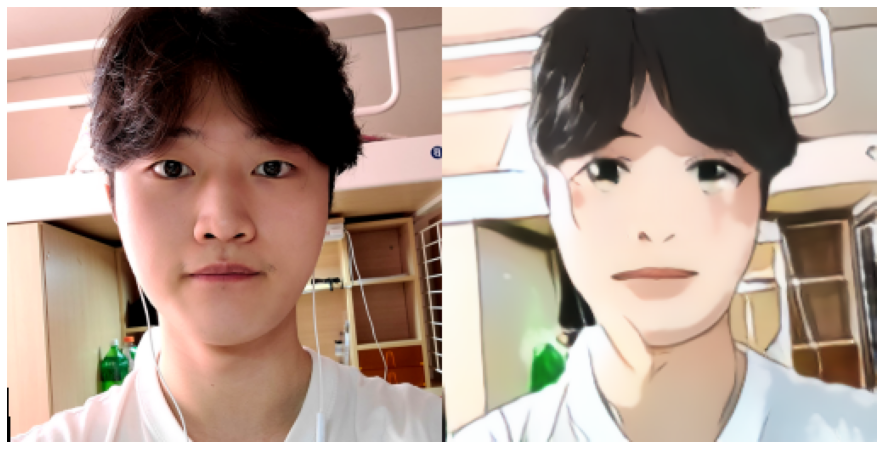

In [ ]:
result = selfie2anime(img)